In [1]:
import scipy.io
import numpy as np

# Load .mat file
file_path = "./PPG_data/Compiled/PPGECG_all.mat"
mat_data = scipy.io.loadmat(file_path)

# Check keys in the .mat file
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'S', 'None', 'fs', 'labels', 'spikes_all', '__function_workspace__'])


In [2]:
import pandas as pd

file_path = "./PPG_data/Compiled/PPGECG_all_table.csv"
df = pd.read_csv(file_path)
df['index'] = df.index

In [3]:
print(df.columns)
print(df.head())

Index(['ID0', 'ID', 'Filename', 'rrmed', 'hrmed', 'sdsd', 'madsd', 'TimeStart',
       'ECGcat', 'index'],
      dtype='object')
     ID0       ID   Filename        rrmed      hrmed       sdsd      madsd  \
0  ID_03  ID_03_1  Sig_001_1  1025.000000  58.536585  14.047703  10.416667   
1  ID_03  ID_03_2  Sig_001_2   991.666667  60.504202  10.346989   6.250000   
2  ID_03  ID_03_3  Sig_001_3   983.333333  61.016949   6.273105   4.166667   
3  ID_03  ID_03_4  Sig_001_4  1000.000000  60.000000   6.804138   6.250000   
4  ID_03  ID_03_5  Sig_001_5  1012.500000  59.259259   4.370037   2.083333   

  TimeStart ECGcat  index  
0  00:00:08   NORM      0  
1  00:00:16   NORM      1  
2  00:00:24   NORM      2  
3  00:00:32   NORM      3  
4  00:00:40   NORM      4  


In [24]:
ECGcat = df['ECGcat'].to_numpy()
print(type(ECGcat))

<class 'numpy.ndarray'>


In [8]:
print(ECGcat.shape)
print(ECGcat[0:5])

(27245,)
['NORM' 'NORM' 'NORM' 'NORM' 'NORM']


In [9]:
summary = (
    df.groupby(['ID0', 'ECGcat'])
    .size()
    .reset_index(name='count')
)

In [10]:
pivot = summary.pivot(index='ID0', columns='ECGcat', values='count').fillna(0)

In [11]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

X = np.array(pivot.index).reshape(-1, 1)  
y = pivot.values  

In [12]:
# First split: train (60%) vs temp (40%)
X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.4)

# Second split: val (20%) vs test (20%) from temp
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

In [13]:
train_patients = X_train.flatten()
val_patients = X_val.flatten()
test_patients = X_test.flatten()

In [14]:
df_train_index = df[df['ID0'].isin(train_patients)]["index"].tolist()
df_val_index = df[df['ID0'].isin(val_patients)]["index"].tolist()
df_test_index = df[df['ID0'].isin(test_patients)]["index"].tolist()

In [132]:
print(df_train_index.head())

3707    3707
3708    3708
3709    3709
3710    3710
3711    3711
Name: index, dtype: int64


In [15]:
PPG_ECG = mat_data['S']
labels = mat_data['labels']
PPG = PPG_ECG[:, :, 0]
ECG = PPG_ECG[:, :, 1]
PPG = np.transpose(PPG)
ECG = np.transpose(ECG)

PPG = np.expand_dims(PPG, axis=1)
PPG = np.expand_dims(PPG, axis=1)

In [16]:
x_train = PPG[df_train_index]
x_val = PPG[df_val_index]
x_test = PPG[df_test_index]

In [17]:
y_train = df[df['ID0'].isin(train_patients)]["ECGcat"]
y_val = df[df['ID0'].isin(val_patients)]["ECGcat"]
y_test = df[df['ID0'].isin(test_patients)]["ECGcat"]

In [25]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
ECGcat = ECGcat
ECGcat = encoder.fit_transform(ECGcat) 

In [28]:
print(type(ECGcat))
print(ECGcat.shape)
print(ECGcat[1:10])

<class 'numpy.ndarray'>
(27245,)
[1 1 1 1 0 1 1 0 1]


In [158]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(14469, 1, 1, 1920)
(5974, 1, 1, 1920)
(6802, 1, 1, 1920)
(14469,)
(5974,)
(6802,)


In [141]:
print(labels)
print(PPG.shape)
print(ECG.shape)
print(PPG_ECG.shape)

[[array(['SPO2'], dtype='<U4') array(['II'], dtype='<U2')]]
(27245, 1920)
(27245, 1920)
(1920, 27245, 2)


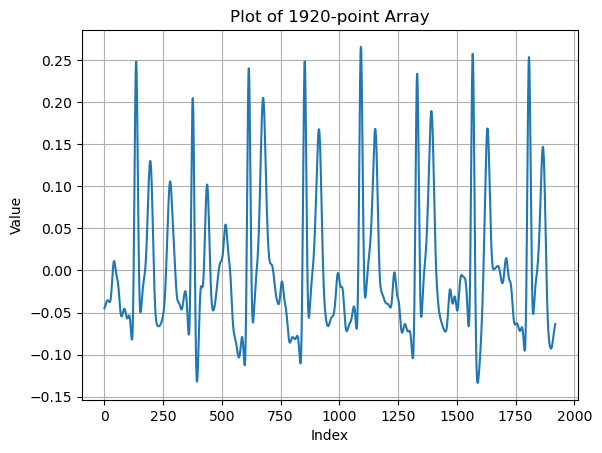

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(ECG[21])
# plt.title("Plot of 1920-point Array")
# plt.xlabel("Index")
# plt.ylabel("Value")
# plt.grid(True)
# plt.show()

In [88]:
rr = mat_data['spikes_all']
rr = rr[0].tolist()  # list of array with shape (1,8)

In [89]:
def calculate_sdsd(rr_intervals):
    """Calculate SDSD from RR intervals."""
    rr_diff = np.diff(rr_intervals)  # Compute successive differences
    sdsd = np.std(rr_diff, ddof=1)  # Standard deviation (unbiased)
    return sdsd

In [90]:
sdsd_all = [] 
for i in rr:
    sdsd = calculate_sdsd(i)
    sdsd_all.append(sdsd.item())

ECG_labels = [1 if i>100 else 0 for i in sdsd_all]
ECG_labels = np.array(ECG_labels)
# ECG_labels_onehot = np.eye(2)[ECG_labels]
ECG_labels_onehot = ECG_labels

In [91]:
print(ECG_labels_onehot.shape)
print(ECG_labels_onehot[:10])

(27245,)
[0 0 0 0 0 1 0 0 1 0]


In [92]:
ectopics = np.array([0, 1])
print(ectopics)

[0 1]


In [93]:
print(len(sdsd_all))
print(len(ECG_labels_onehot))
print(ECG_labels_onehot.shape)
print(type(ECG_labels_onehot[0]))
print(sum([i == ectopics for i in ECG_labels_onehot]))

27245
27245
(27245,)
<class 'numpy.int64'>
[14464 12781]


In [94]:
from sklearn.model_selection import train_test_split

In [95]:
print(PPG.shape)
PPG = np.expand_dims(PPG, axis=1)
PPG = np.expand_dims(PPG, axis=1)

(27245, 1920)


In [96]:
x_train, x_rest, y_train, y_rest = train_test_split(PPG, ECG_labels_onehot, test_size=0.4, random_state=16, shuffle=True)

In [97]:
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.5, random_state=16, shuffle=True)

In [98]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(16347, 1, 1, 1920)
(16347,)
(5449, 1, 1, 1920)
(5449,)
(5449, 1, 1, 1920)
(5449,)


In [99]:
print(len(x_train))

16347


In [100]:
with open('./PPG_data/splitted_data/x_train.npy', 'wb') as f:
    np.save(f, x_train)
with open('./PPG_data/splitted_data/y_train.npy', 'wb') as f:
    np.save(f, y_train)
with open('./PPG_data/splitted_data/x_val.npy', 'wb') as f:
    np.save(f, x_val)
with open('./PPG_data/splitted_data/y_val.npy', 'wb') as f:
    np.save(f, y_val)
with open('./PPG_data/splitted_data/x_test.npy', 'wb') as f:
    np.save(f, x_test)
with open('./PPG_data/splitted_data/y_test.npy', 'wb') as f:
    np.save(f, y_test)